In [1]:
from imutils import paths
import matplotlib.pyplot as plt
import argparse
import os
import cv2
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
from sklearn import metrics
from keras.preprocessing import image
from keras.models import load_model
import scikitplot as skplt
import matplotlib.pyplot as plt


In [2]:
path = "dataset"
imagespath = list(paths.list_images(path))
imagearr = []
labelarr = []

#Load images and labelarr into arrays
for imagepath in imagespath:
    image = cv2.imread(imagepath)
    image = cv2.resize(image, (224, 224))
    imagearr.append(image)
    label = imagepath.split(os.path.sep)[-2]
    labelarr.append(label)
    

#Normalize the images and convert to numpy arrays
imagearr = np.array(imagearr) / 255.0
labelarr = np.array(labelarr)

# print(imagearr, labelarr)

# Convert labels from yes and no to 1 and 0
labelbinarizer = LabelBinarizer()
labelarr = labelbinarizer.fit_transform(labelarr)
labelarr = to_categorical(labelarr)


In [3]:
#Split data into training and testing sets
(trainX, testX, trainY, testY) = train_test_split(imagearr, labelarr, test_size=0.1,
                                                  random_state=42, stratify=labelarr)

# Mutate images so that the training data pool is larger
mutatedimages = ImageDataGenerator(fill_mode = 'nearest', rotation_range = 15)

In [4]:
# Use Transfer Learning - take representations from a pretrained model(VGG16)
base = VGG16(weights = 'imagenet', input_tensor = Input(shape = (224, 224, 3)), include_top = False)

# Add needed layers
baseoutput = base.output
baseoutput = AveragePooling2D(pool_size = (4,4))(baseoutput)
baseoutput = Flatten(name = "flatten")(baseoutput)
baseoutput = Dense(64, activation = "relu")(baseoutput)
baseoutput = Dropout(0.5)(baseoutput)
baseoutput = Dense(2, activation = "softmax")(baseoutput)

# Freeze the layers so that the next layers aren't trained from scratch each time
for layer in base.layers:
    layer.trainable = False

# Build and compile the model
baseinput = base.input
model = Model(inputs = baseinput, outputs = baseoutput)
model.compile(optimizer = Adam(learning_rate = 1e-3), metrics = ['accuracy'], loss = 'binary_crossentropy')

# model.summary()

In [5]:
batchsize = 8
epochs = 10
trainingsteps = len(trainX)//batchsize
validationsteps = len(testX)//batchsize

In [6]:
#Train the model and display results of different epochs
# history = model.fit(mutatedimages.flow(trainX, trainY, batch_size= batchsize),
#  steps_per_epoch= trainingsteps, validation_data = (testX, testY), validation_steps= validationsteps, epochs= epochs)

model.fit(mutatedimages.flow(trainX, trainY, batch_size= batchsize),
 steps_per_epoch= trainingsteps, validation_data = (testX, testY), validation_steps= validationsteps, epochs= epochs)

Epoch 1/10
28/28 [==============================] - 30s 1s/step - loss: 0.6911 - accuracy: 0.5571 - val_loss: 0.5960 - val_accuracy: 0.6154
Epoch 2/10
28/28 [==============================] - 29s 1s/step - loss: 0.6375 - accuracy: 0.6530 - val_loss: 0.5624 - val_accuracy: 0.6154
Epoch 3/10
28/28 [==============================] - 29s 1s/step - loss: 0.6347 - accuracy: 0.6575 - val_loss: 0.5373 - val_accuracy: 0.9615
Epoch 4/10
28/28 [==============================] - 30s 1s/step - loss: 0.5835 - accuracy: 0.7143 - val_loss: 0.4739 - val_accuracy: 0.8846
Epoch 5/10
28/28 [==============================] - 29s 1s/step - loss: 0.5799 - accuracy: 0.7397 - val_loss: 0.4412 - val_accuracy: 0.9231
Epoch 6/10
28/28 [==============================] - 29s 1s/step - loss: 0.5592 - accuracy: 0.7443 - val_loss: 0.4163 - val_accuracy: 0.9231
Epoch 7/10
28/28 [==============================] - 29s 1s/step - loss: 0.5473 - accuracy: 0.7489 - val_loss: 0.3797 - val_accuracy: 0.9231
Epoch 8/10
28/28 [==

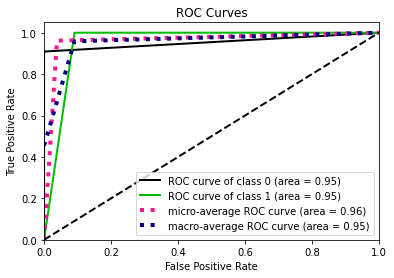

In [7]:
y_true = testY
y_probas = model.predict(testX, batch_size= batchsize)
predictions = np.argmax(y_probas, axis= 1)
skplt.metrics.plot_roc(predictions, testY)
plt.show()

In [8]:
#Evaluation
actualresults = np.argmax(testY, axis= 1)
predictions = model.predict(testX, batch_size= batchsize)
predictions = np.argmax(predictions, axis= 1)

print(classification_report(actualresults, predictions, target_names= labelbinarizer.classes_))
confmatrix = confusion_matrix(actualresults, predictions)

print(confmatrix)

#Print accuracy of model
total = sum(sum(confmatrix))
accuracy = (confmatrix[0, 0] + confmatrix[1, 1]) / total
print("Accuracy: {:.4f}".format(accuracy))


              precision    recall  f1-score   support

          no       0.91      1.00      0.95        10
         yes       1.00      0.94      0.97        16

    accuracy                           0.96        26
   macro avg       0.95      0.97      0.96        26
weighted avg       0.97      0.96      0.96        26

[[10  0]
 [ 1 15]]
Accuracy: 0.9615


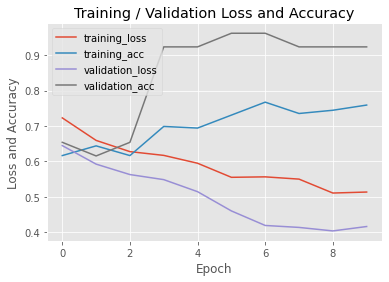

In [ ]:
#Plot loss/accuracy results of different model epochs
plt.style.use("ggplot")
plt.figure()

plt.plot(np.arange(0, epochs), history.history["loss"], label= "training_loss")
plt.plot(np.arange(0, epochs), history.history["accuracy"], label= "training_acc")
plt.plot(np.arange(0, epochs), history.history["val_loss"], label= "validation_loss")
plt.plot(np.arange(0, epochs), history.history["val_accuracy"], label= "validation_acc")

plt.title("Training / Validation Loss and Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Loss and Accuracy")
plt.legend()
plt.savefig("plot.jpg")